### Libraries used ###

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import re
import html
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, mean_squared_error
sb.set()

### Dataset Used ###

In [2]:
steamData = pd.read_csv('games.csv')

In [3]:
list(steamData.columns)

['AppID',
 'Name',
 'Release date',
 'Estimated owners',
 'Peak CCU',
 'Required age',
 'Price',
 'DLC count',
 'About the game',
 'Supported languages',
 'Full audio languages',
 'Reviews',
 'Header image',
 'Website',
 'Support url',
 'Support email',
 'Windows',
 'Mac',
 'Linux',
 'Metacritic score',
 'Metacritic url',
 'User score',
 'Positive',
 'Negative',
 'Score rank',
 'Achievements',
 'Recommendations',
 'Notes',
 'Average playtime forever',
 'Average playtime two weeks',
 'Median playtime forever',
 'Median playtime two weeks',
 'Developers',
 'Publishers',
 'Categories',
 'Genres',
 'Tags',
 'Screenshots',
 'Movies']

The columns of the dataset

In [4]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

steamData.head()

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,Full audio languages,Reviews,Header image,Website,Support url,Support email,Windows,Mac,Linux,Metacritic score,Metacritic url,User score,Positive,Negative,Score rank,Achievements,Recommendations,Notes,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,['English'],[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://www.galacticbowling.net,NaN,NaN,True,False,False,0,NaN,0,6,11,NaN,30,0,NaN,0,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://trainbandit.com,NaN,support@rustymoyher.com,True,True,False,0,NaN,0,53,5,NaN,12,0,NaN,0,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,NaN,ramoncampiaof31@gmail.com,True,False,False,0,NaN,0,0,0,NaN,0,0,NaN,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://henosisgame.com/,https://henosisgame.com/,info@henosisgame.com,True,True,True,0,NaN,0,3,0,NaN,0,0,NaN,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://www.unusual-games.com/home/,https://www.unusual-games.com/contact/,welistentoyou@unusual-games.com,True,True,False,0,NaN,0,50,8,NaN,17,0,This Game may contain content not appropriate ...,0,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


First 5 rows of the dataset to show us a sample of how the data looks like

### Finding out the correlation between numeric data columns and the number of reviews

<Axes: >

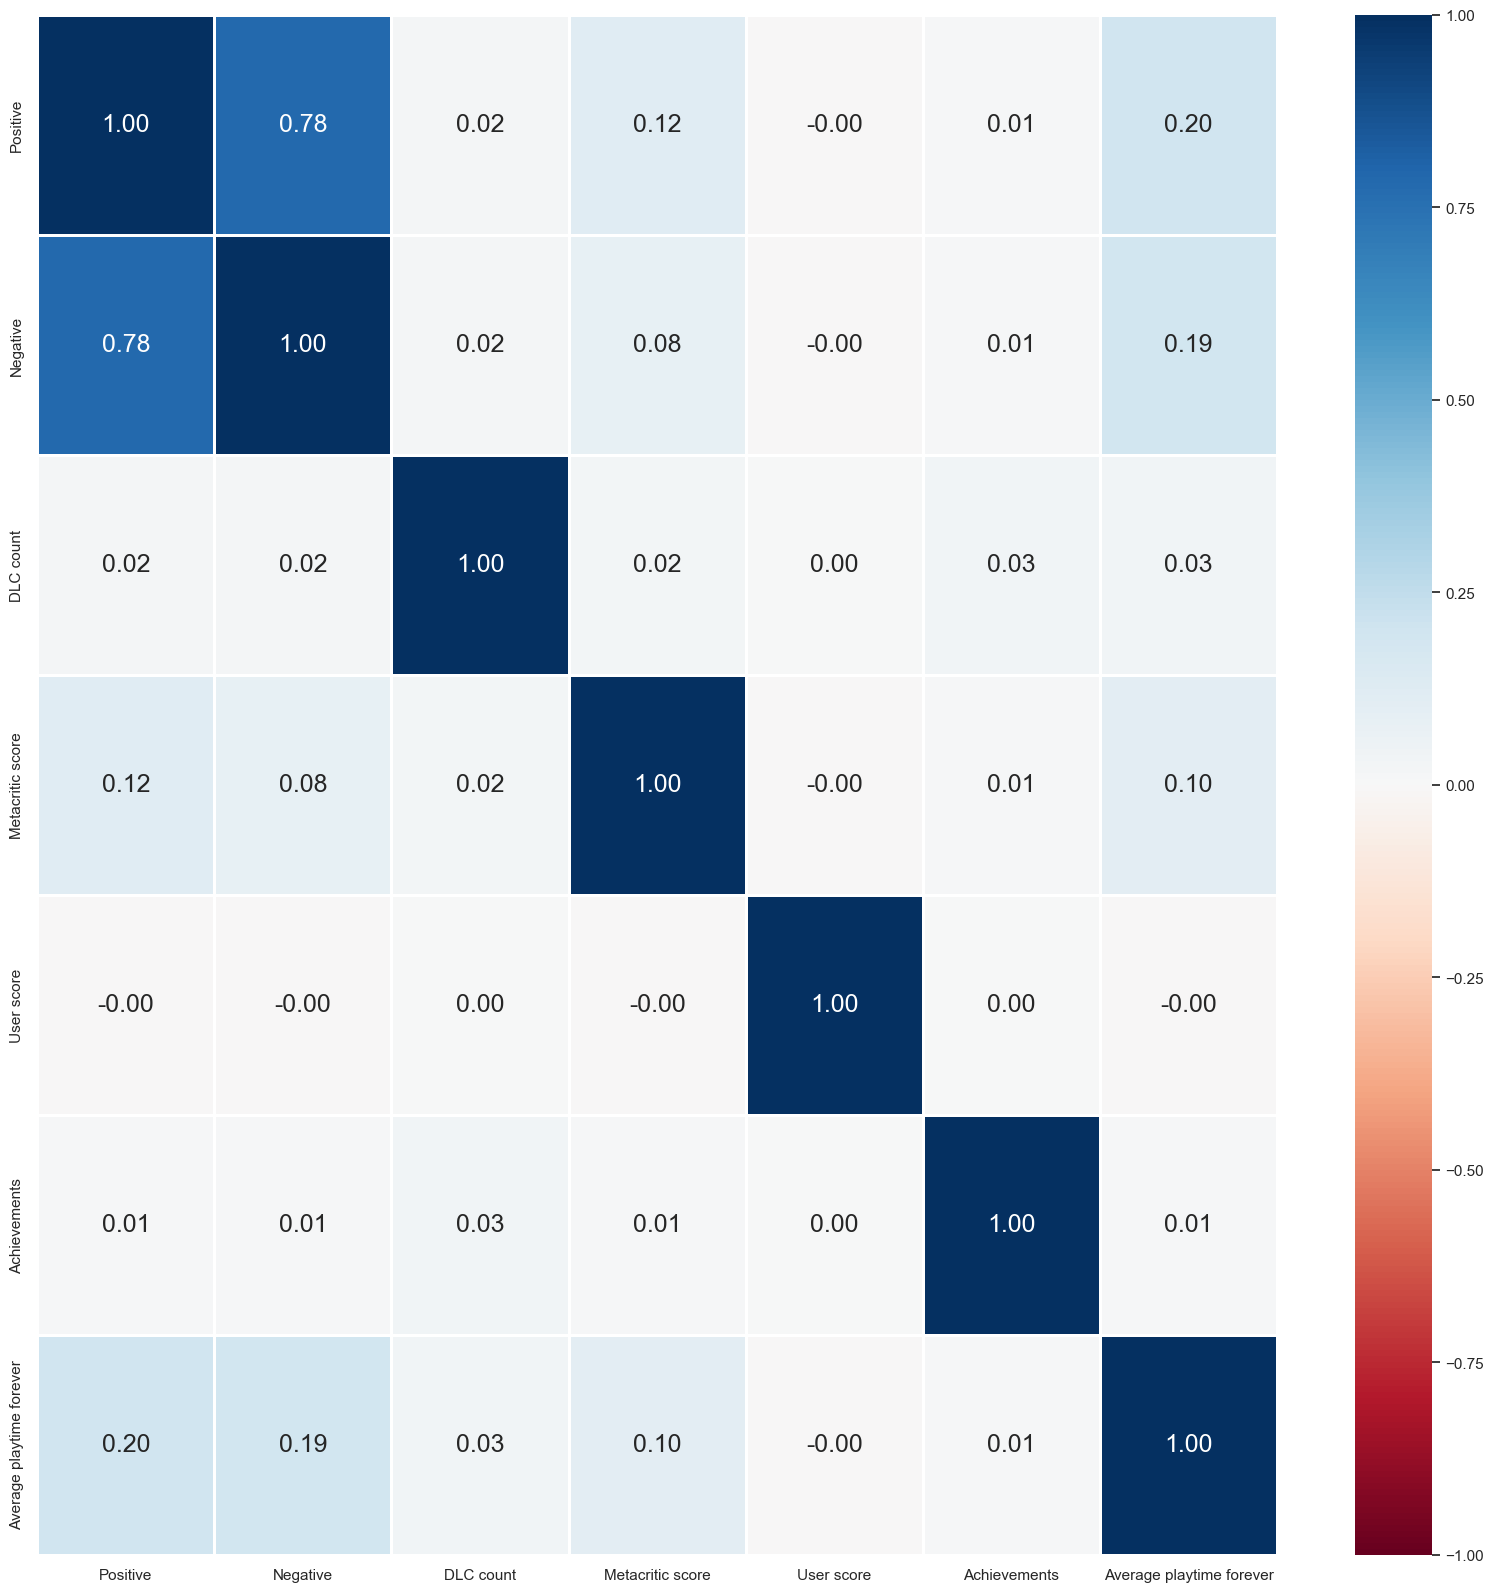

In [14]:
numeric_columns = ['Positive', 'Negative', 'DLC count', 'Metacritic score', 'User score', 'Achievements', 
           'Average playtime forever']

corrWithReviews = steamData[numeric_columns]

corrWithReviews = corrWithReviews.drop(corrWithReviews[(corrWithReviews.Positive == 0) & (corrWithReviews.Negative == 0)].index)

# Correlation Matrix
corrWithReviews.corr()

# Heatmap of the Correlation Matrix
f = plt.figure(figsize=(20, 20))
sb.heatmap(corrWithReviews.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

As you can see in this heatmap, there isn't much correlation between any of this numeric data and positive and negative reviews. The highest is average playtime is only 0.2. Since there isn't much correlation, we shall move to see if the categorical data has any correlation with the number of reviews

### Finding out the relationship between categorical data and number of reviews
We have identified a few columns to work with, namely `Supported Languages`, `Categories` and `Publishers`

### Functions definitions ###

In [7]:
# This function is clean up html elements and remove special characters and specific characters before printing out
def clean_name(name):
    name = html.unescape(name)
    name = re.sub(r'<[^>]*>', '', name)
    name = re.sub(r'\brn\b', '', name, flags=re.IGNORECASE) 
    name = re.sub(r'\bbr\b', '', name, flags=re.IGNORECASE)
    name = re.sub(r'\blt\b|\bgt\b', '', name, flags=re.IGNORECASE)
    name = re.sub(r'\bstrong\b', '', name, flags=re.IGNORECASE)
    name = re.sub(r'[^a-zA-Z\s,-]', '', name)
    name = re.sub(r'\s+', ' ', name)
    name = name.strip()
    return name

# As each entry in the column may have multiple values that is split by a comma, this is to split them up
# For example, 'English', 'Dutch', 'Chinese' etc.
def split_and_clean(name):
    cleaned_name = clean_name(name)
    parts = [part.strip() for part in cleaned_name.split(',')]
    valid_entries = []
    for part in parts:
        if not re.search(r'(bb|rn)', part, flags=re.IGNORECASE) and re.match(r'^[a-zA-Z\s-]+$', part):
            valid_entries.append(part)
    return valid_entries

# Define a normalization function to group publishers
def group_publisher(publisher):
    if not isinstance(publisher, str):
        return "Unknown"     
    normalized = publisher.lower().strip()
    for known_publisher in publishers:
        if known_publisher.lower() in normalized:
            return known_publisher
    return publisher

In [8]:
languageCorr = ['Positive', 'Negative', "Supported languages"]
langWithReviews = steamData[languageCorr]
langWithReviews = langWithReviews.drop(langWithReviews[(langWithReviews.Positive == 0) & (langWithReviews.Negative == 0)].index)

langWithReviews['Supported languages'] = langWithReviews['Supported languages'].astype(str).apply(split_and_clean)

languages = pd.Series([lang for sublist in langWithReviews['Supported languages'] for lang in sublist])

clean_languages = sorted(set(languages))

for lang in clean_languages:
    if lang == 'langfranais':
        continue
    print(lang)

Afrikaans
Albanian
Amharic
Arabic
Armenian
Assamese
Azerbaijani
Bangla
Basque
Belarusian
Bosnian
Bulgarian
Catalan
Cherokee
Croatian
Czech
Danish
Dari
Dutch
English
English Dutch English
English full audio
Estonian
Filipino
Finnish
French
Galician
Georgian
German
Greek
Gujarati
Hausa
Hebrew
Hindi
Hungarian
Icelandic
Igbo
Indonesian
Irish
Italian
Japanese
Japanese all with full audio support
Kannada
Kazakh
Khmer
Kiche
Kinyarwanda
Konkani
Korean
Kyrgyz
Latvian
Lithuanian
Luxembourgish
Macedonian
Malay
Malayalam
Maltese
Maori
Marathi
Mongolian
Nepali
Norwegian
Odia
Persian
Polish
Portuguese
Portuguese - Brazil
Portuguese - Portugal
Punjabi Gurmukhi
Punjabi Shahmukhi
Quechua
Romanian
Russian
Scots
Serbian
Simplified Chinese
Sindhi
Sinhala
Slovak
Slovakian
Slovenian
Sorani
Sotho
Spanish - Latin America
Spanish - Spain
Swahili
Swedish
Tajik
Tamil
Tatar
Telugu
Thai
Tigrinya
Traditional Chinese
Traditional Chinese text only
Tswana
Turkish
Turkmen
Ukrainian
Urdu
Uyghur
Uzbek
Valencian
Vietnames

This is all the supported languages available for all the games found in the dataset

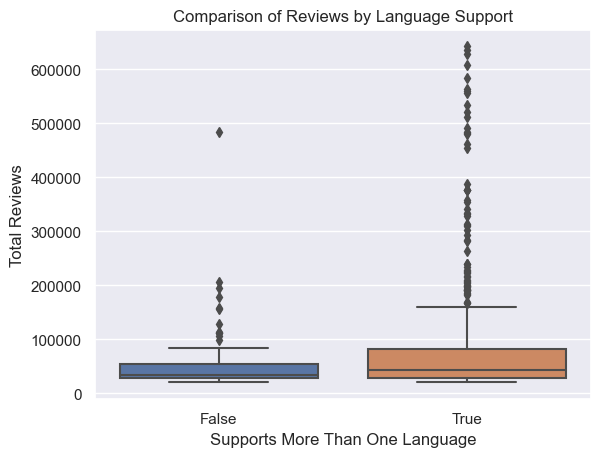

In [9]:
numberOfLanguages = [len(i) for i in langWithReviews['Supported languages']]
hasMoreThanOne = [i > 1 for i in numberOfLanguages] 
totalReviews = [(i+j) for i,j in zip(langWithReviews['Positive'], langWithReviews['Negative'])]

langWithReviews = langWithReviews.assign(
    TotalReviews=totalReviews,
    MoreThanOneLanguage=hasMoreThanOne
)

analysis_df = langWithReviews[['TotalReviews', 'MoreThanOneLanguage']]

filtered_df = analysis_df.loc[(analysis_df['TotalReviews'] > 20000) & (analysis_df['TotalReviews'] < 700000)]

sb.boxplot(x='MoreThanOneLanguage', y='TotalReviews', data=filtered_df)
plt.title('Comparison of Reviews by Language Support')
plt.xlabel('Supports More Than One Language')
plt.ylabel('Total Reviews')
plt.show()

As we can see in the above box plot, when the game supports more than one language, the total number of reviews will be higher. As seen by the median of total reviews column when the games support only one language (meaning false) is lesser than when there is support for more than one language. This data may not be representative of the correlation between the number of reviews and the support for languages, so let's look at the following catplot.

/Users/zent-zaxux/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


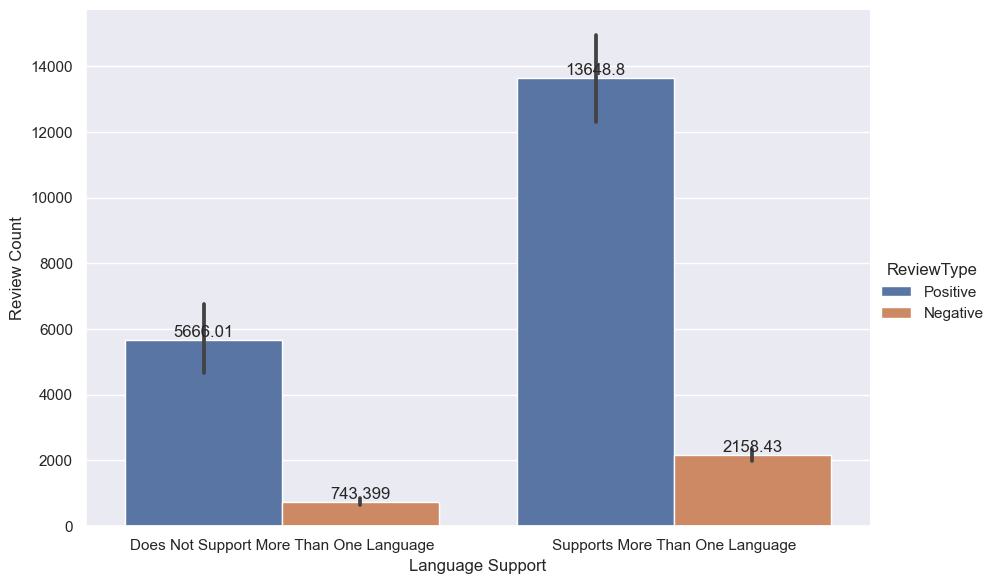

In [10]:
analysis_df = langWithReviews[['Positive', 'Negative', 'MoreThanOneLanguage', 'TotalReviews']]
analysis_df = analysis_df.loc[(analysis_df['TotalReviews'] > 1000) & (analysis_df['TotalReviews'] < 700000)]

long_df = analysis_df.melt(id_vars=["MoreThanOneLanguage"], value_vars=["Positive", "Negative"], 
                           var_name="ReviewType", value_name="Count")

custom_labels = {False: 'Does Not Support More Than One Language', True: 'Supports More Than One Language'}

g = sb.catplot(x="MoreThanOneLanguage", y="Count", hue="ReviewType", data=long_df, kind="bar", height=6, aspect=1.5)

g.set_axis_labels("Language Support", "Review Count")
g.set_titles("Comparison of Reviews by Language Support")

g.set_xticklabels([custom_labels[False], custom_labels[True]])

ax = g.facet_axis(0, 0)
for c in ax.containers:
    ax.bar_label(c, label_type='edge') 

plt.show()

This is a catplot. Each bar represent the average number of reviews for both positive and negative for games supporting more than one language versus those that don't. The line on the top represent the precision of this average. As you can see for the negative reviews for games that do not support more than one language (In this case, the game only has English as its default language)

It means that the negative reviews of most of the games are very close to the average number of negative reviews. (It is clustered around the mean). This means that it offers a high confidence in the representation for the mean of the data. As for the positive reviews for games that support more than one language, there is a higher variation in the data and less certainty about the exact value of the mean. This can be seen by the longer line which represents the longer spread, that the data points is quite far from the average number of positive reviews. Suggesting that the mean is less representative of any individual data point.

You can also see that there are more generally more positive and negative reviews when the games supports more than one language.

In [11]:
categories = ['Single-player', 'Multi-player', 'MMO', 'Full controller support']

categWithReviews = ['Positive', 'Negative', 'Categories']
categCorr = steamData[categWithReviews]

categCorr = categCorr.drop(corrWithReviews[(corrWithReviews.Positive == 0) & (corrWithReviews.Negative == 0)].index)

categCorr['Categories'] = categCorr['Categories'].astype(str).apply(split_and_clean)
category_series = pd.Series([catg for sublist in categCorr['Categories'] for catg in sublist])

clean_categories = sorted(set(category_series))

for categ in clean_categories:
    if categ in ["nan"]:
        continue
    print(categ)

Captions available
Co-op
Commentary available
Cross-Platform Multiplayer
Full controller support
HDR available
In-App Purchases
Includes Source SDK
Includes level editor
LAN Co-op
LAN PvP
MMO
Mods
Mods require HL
Multi-player
Online Co-op
Online PvP
Partial Controller Support
PvP
Remote Play Together
Remote Play on Phone
Remote Play on TV
Remote Play on Tablet
SharedSplit Screen
SharedSplit Screen Co-op
SharedSplit Screen PvP
Single-player
Stats
Steam Achievements
Steam Cloud
Steam Leaderboards
Steam Trading Cards
Steam Workshop
SteamVR Collectibles
Tracked Controller Support
Tracked Motion Controller Support
VR Only
VR Support
VR Supported
Valve Anti-Cheat enabled


This is the different categories of all the game found in the dataset, and we have chosen a few to find the relationship between them and total reviews

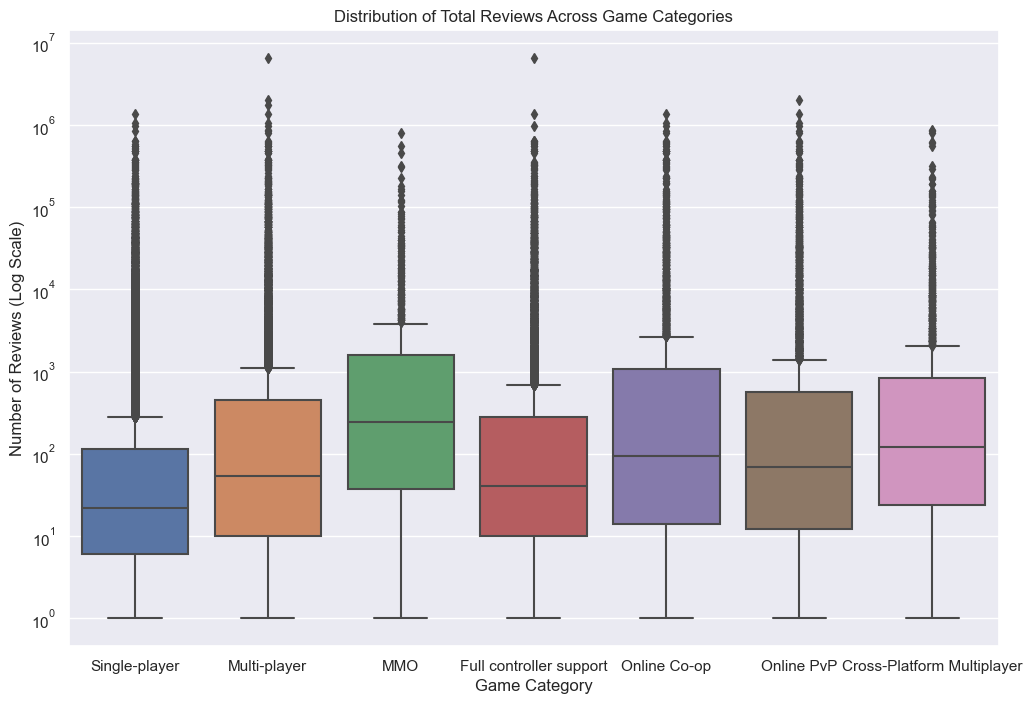

In [12]:
steamData['Total_Reviews'] = steamData['Positive'] + steamData['Negative']

categories_of_interest = ['Single-player', 'Multi-player', 'MMO', 'Full controller support', 'Online Co-op', 'Online PvP', 'Cross-Platform Multiplayer']

steamData['Categories'] = steamData['Categories'].astype(str).apply(split_and_clean)

def has_category(x, category):
    return category in x

for category in categories_of_interest:
    steamData[category] = steamData['Categories'].apply(lambda x: has_category(x, category))

filtered_data = steamData[(steamData['Positive'] > 0) | (steamData['Negative'] > 0)]

melted_data = filtered_data.melt(id_vars=['Total_Reviews'], value_vars=categories_of_interest,
                                 var_name='Category', value_name='Has_Category')

melted_data = melted_data[melted_data['Has_Category'] == True]

plt.figure(figsize=(12, 8))
sb.boxplot(data=melted_data, x='Category', y='Total_Reviews')
plt.title('Distribution of Total Reviews Across Game Categories')
plt.yscale('log')  # Using a logarithmic scale due to the wide range of review counts
plt.xlabel('Game Category')
plt.ylabel('Number of Reviews (Log Scale)')
plt.show()


This Python code snippet utilizes the pandas library to manipulate a DataFrame steamData, augmenting it with a new column 'Total_Reviews' that sums the values of 'Positive' and 'Negative' reviews for each game. It defines a list of game categories of interest and cleanses the 'Categories' column using a user-defined function split_and_clean, which processes strings to filter and structure category data. The code then checks for the presence of each category of interest in the cleaned categories list, creating a new boolean column for each category. Rows without any reviews are excluded to focus the analysis on games with feedback. The data is reshaped using pd.melt for visualization, filtering only games with the category present. A seaborn boxplot visualizes the distribution of total reviews across the selected game categories, using a logarithmic scale to manage the wide range of review counts, effectively displaying how review distributions vary by game category. This allows for an analytical view of player engagement and popularity across different types of game features.

I want to analyse whether the different categories affect the number of reviews of the game. As seen above in the box plot, it seems that MMO games tend to have higher reviews and lesser outliers

Selected Publishers for Analysis:
                   Publishers  TotalReviews
0       Smartly Dressed Games        484705
1                  Activision        629454
2                      Funcom        124359
3                    Re-Logic        986907
4  BANDAI NAMCO Entertainment        725725
5                       ZA/UM         58494
6              GSC Game World         64519
7    7th Beat Games,indienova         58365
8            VOID Interactive         60201
9              Amistech Games         43415


/var/folders/94/q6fc69_12h7dtf0dbvcfh6240000gn/T/ipykernel_9100/191568980.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pubCorr['TotalReviews'] = pubCorr['Positive'] + pubCorr['Negative']


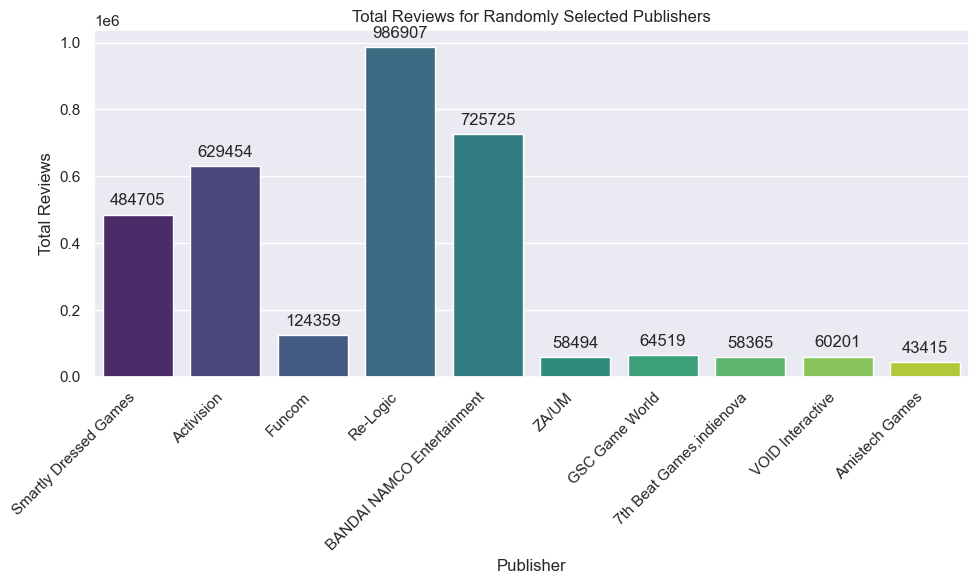

In [13]:
pubWithReviews = ['Positive', 'Negative', 'Publishers']
pubCorr = steamData[pubWithReviews]

pubCorr['TotalReviews'] = pubCorr['Positive'] + pubCorr['Negative']

publisher_reviews = pubCorr.groupby('Publishers').agg({
    'Positive': 'sum',
    'Negative': 'sum',
    'TotalReviews': 'sum'
})

publisher_reviews = publisher_reviews[publisher_reviews['TotalReviews'] >= 20000]

quantiles = publisher_reviews['TotalReviews'].quantile([0.25, 0.75])

top_publishers = publisher_reviews[publisher_reviews['TotalReviews'] >= quantiles[0.75]]

middle_publishers = publisher_reviews[(publisher_reviews['TotalReviews'] > quantiles[0.25]) & (publisher_reviews['TotalReviews'] < quantiles[0.75])]

random_top = top_publishers.sample(n=min(5, len(top_publishers)), random_state=42)  
random_middle = middle_publishers.sample(n=min(5, len(middle_publishers)), random_state=42)

combined_publishers = pd.concat([random_top, random_middle]).reset_index()

print("Selected Publishers for Analysis:")
print(combined_publishers[['Publishers', 'TotalReviews']])

plt.figure(figsize=(10, 6))
ax = sb.barplot(data=combined_publishers, x='Publishers', y='TotalReviews', palette='viridis')
plt.title('Total Reviews for Randomly Selected Publishers')
plt.xlabel('Publisher')
plt.ylabel('Total Reviews')
plt.xticks(rotation=45, ha="right")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

plt.tight_layout()
plt.show()


This Python script uses the pandas library to process and analyze data regarding Steam publishers from a DataFrame named steamData, focusing on the number of reviews each publisher receives. Initially, it calculates the total reviews by summing up positive and negative reviews for each game, then aggregates these reviews at the publisher level, and excludes any publisher with fewer than 20,000 total reviews. It identifies and separates publishers into two distinct groups based on their review counts: those in the top 25% and those in the middle 50%, using calculated quantiles of total reviews. From these groups, the script randomly selects up to five publishers from each, combines these selected publishers into a single DataFrame, and then visualizes the total reviews for these publishers using a seaborn bar plot. This plot is annotated with the exact review counts above each bar, providing a clear, visual representation of the comparative review volumes of randomly selected top and middle-tier publishers, illustrating potential correlations between publisher popularity and the volume of received reviews.

The purpose of this code is to dynamically find the publishers that is most popular in terms of the total number of reviews received by all of their games. I want to find out whether is there any correlation between publisher and number of reviews they received for the games that they published. 